Let's start by loading the dataset:


In [5]:
import keras

img_width = 160
img_height = 160

train_ds = keras.utils.image_dataset_from_directory(
    'input/vggface2/train',
    image_size=(img_height, img_width),
    batch_size=None)

val_ds = keras.utils.image_dataset_from_directory(
    'input/vggface2/val',
    image_size=(img_height, img_width),
    batch_size=None)

train_ds = train_ds.take(len(train_ds) // 1000)
val_ds = val_ds.take(len(val_ds) // 1000)

Found 176398 files belonging to 480 classes.
Found 21295 files belonging to 60 classes.


In [6]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


def extract_face(image, minSize=(60, 60)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    faces = face_classifier.detectMultiScale(
        gray_image, scaleFactor=1.1, minNeighbors=5, minSize=minSize)
    if len(faces) > 0:
        x, y, w, h = faces[-1]
        face = image[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (img_height, img_width))
        return face_resized
    return None


def preprocess_dataset(dataset):
    images = []
    labels = []
    for image, label in dataset:
        face = extract_face(image.numpy())
        if face is not None:
            images.append(face)
            labels.append(label.numpy())

    return np.array(images), np.array(labels)

In [7]:
x_train, y_train = preprocess_dataset(train_ds)
x_test, y_test = preprocess_dataset(val_ds)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (147, 160, 160, 3)
y_train shape: (147,)


2024-12-18 20:39:18.402771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-18 20:39:18.598612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's now display some of the images with their labels:


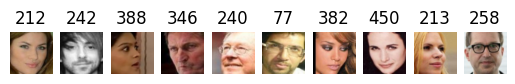

In [8]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i].astype('uint8'))
    plt.title(y_train[i])
    plt.axis("off")

We'll train a Siamese Network using positive and negative pairs of images. A positive pair consists of two images representing the same person, while a negative pair consists of two images representing different people.


In [9]:
import numpy as np


def generate_pairs(x, y):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same person. A negative pair contains
    two images representing different people.
    """

    x_pairs = []
    y_pairs = []

    for i in range(len(x)):
        person = y[i]

        # Find a random image representing the same person.
        # This is a positive pair.
        positive_indices = np.where(y == person)[0]
        if len(positive_indices) == 1:
            continue
        positive_indices = positive_indices[positive_indices != i]
        positive_person_index = np.random.choice(positive_indices)

        # Add the pair of images to the list.
        x_pairs.append([x[i], x[positive_person_index]])

        # Since this is a positive pair, the ground truth label is 0.
        # The distance between images representing the same person should be small,
        # and that's why we use 0 as the label.
        y_pairs.append([0])

        # Find a random image representing a different people.
        # This is a negative pair.
        negative_person_index = np.random.choice(np.where(y != person)[0])

        # Add the pair of images to the list.
        x_pairs.append([x[i], x[negative_person_index]])

        # Since this is a negative pair, the ground truth label is 1.
        # The distance between images representing different person should be large,
        # and that's why we use 1 as the label.
        y_pairs.append([1])

    indices = np.arange(len(x_pairs))
    np.random.shuffle(indices)

    return np.array(x_pairs)[indices], np.array(y_pairs)[indices]

Let's generate the pairs for training and testing the model:


In [10]:
x_train_pairs, y_train_pairs = generate_pairs(x_train, y_train)
x_test_pairs, y_test_pairs = generate_pairs(x_test, y_test)

print("x_train_pairs shape:", x_train_pairs.shape)
print("x_test_pairs shape:", x_test_pairs.shape)

x_train_pairs shape: (96, 2, 160, 160, 3)
x_test_pairs shape: (14, 2, 160, 160, 3)


Let's display some of these pairs to ensure they were generated correctly:


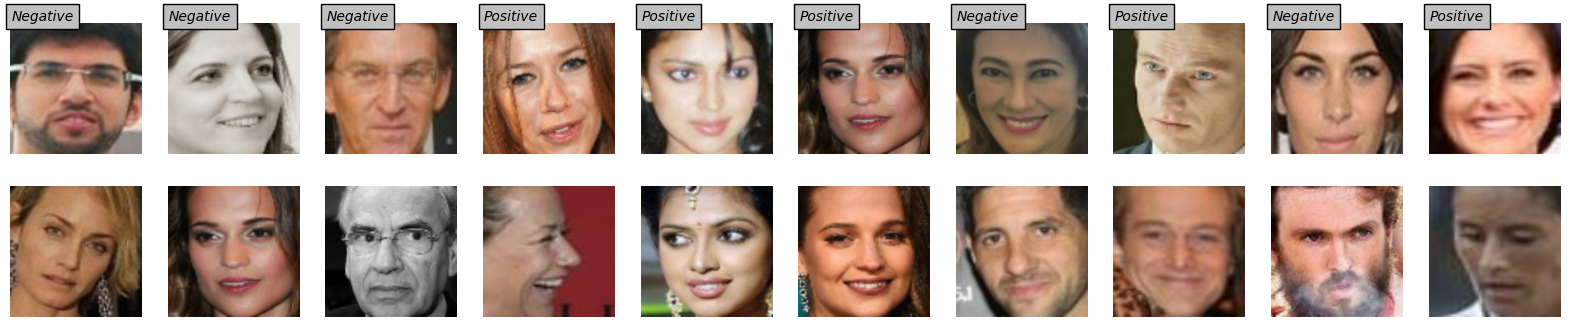

In [11]:
def display_pairs(x, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - x: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(x[:n, 0], x[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.astype('uint8'))
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.astype('uint8'))
        plt.axis("off")

    plt.show()


display_pairs(x_train_pairs, y_train_pairs)

It's time to start building the Siamese Network. Let's first define the inputs that will receive the pair of images:


In [12]:
from keras import Input

input1 = Input(shape=(img_height, img_width, 3))
input2 = Input(shape=(img_height, img_width, 3))

Then, we can build the body of the Siamese Network. This network will be responsible of generating the embeddings for each of the input images:


In [13]:
from keras.layers import Rescaling, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential
from keras.applications import ResNet50

resnet = ResNet50(weights='imagenet', include_top=False,
                  input_shape=(img_height, img_width, 3))

network = Sequential(
    [
        Rescaling(1/255),
        resnet,
        GlobalAveragePooling2D(),
        Dense(512, activation=None),
        Dropout(0.3),
        Dense(256, activation=None),
        Dropout(0.3),
        Dense(128, activation=None)
    ]
)

Our network will have two branches, each one responsible for processing one of the images in the pair. We want to share the same weights between the branches, so we'll use the same network instance:


In [14]:
twin1 = network(input1)
twin2 = network(input2)

The output of the Siamese Network will be the distance between the embeddings of the two images. To do this, we can use a Lambda layer to calculate the Euclidean distance between the embeddings:


In [15]:
from keras.layers import Lambda
from keras.ops import norm


def euclidean_distance(twins):
    """Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)


distance = Lambda(euclidean_distance)([twin1, twin2])

Let's now set up the model:


In [16]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

We'll use the Contrastive Loss to train the model.


In [17]:
from keras.ops import cast, maximum, square


def contrastive_loss(y, d):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """

    margin = 1
    y = cast(y, d.dtype)

    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))

    return loss

Let's compile the model using the Contrastive Loss:


In [18]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam",
              metrics=[binary_accuracy])

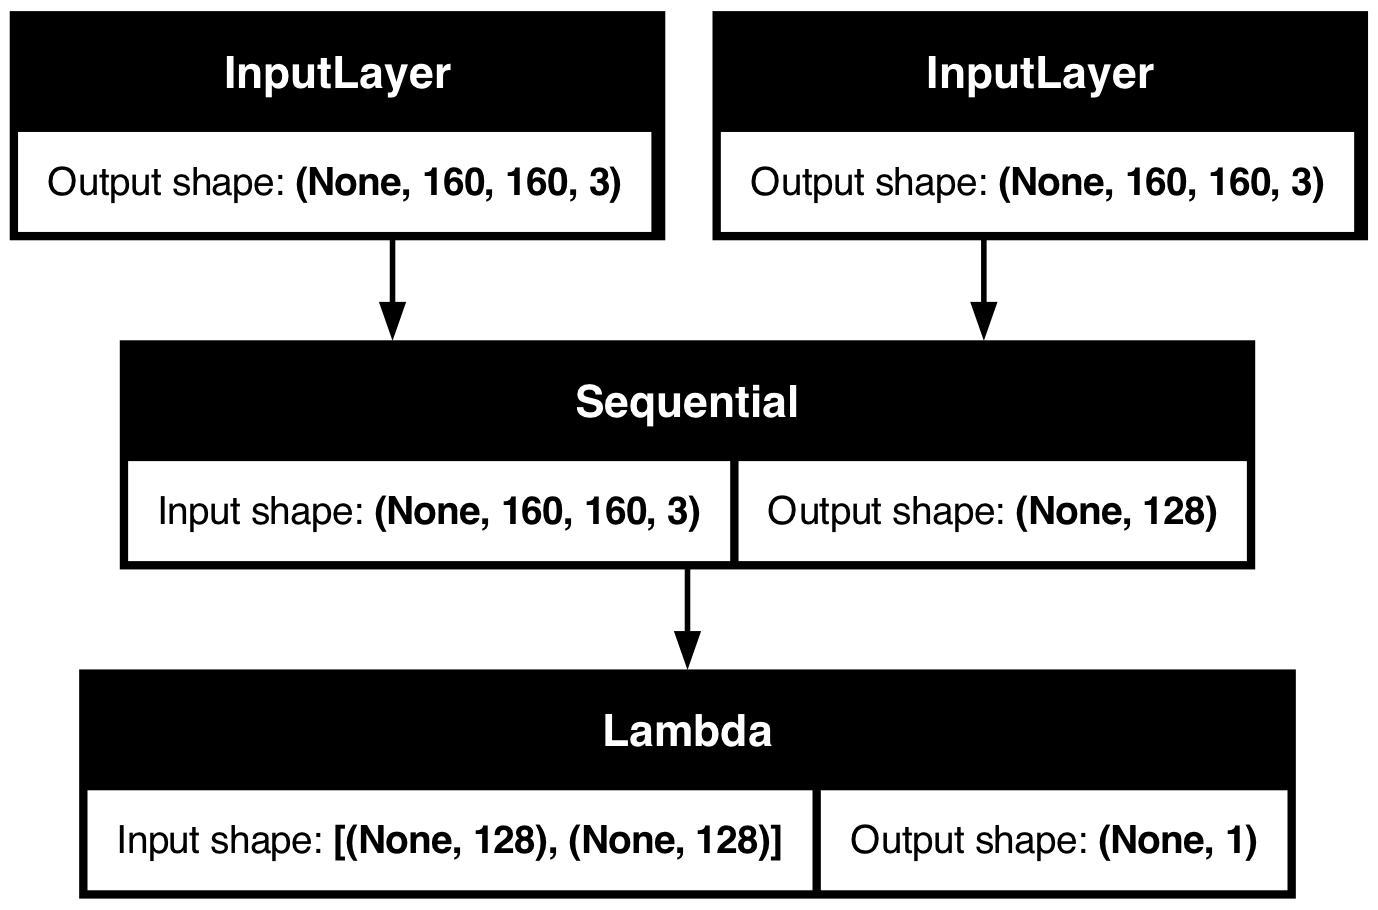

In [19]:
keras.utils.plot_model(
    model, to_file="output/model.png", show_shapes=True, show_layer_names=False
)

Let's fit the model:


In [20]:
history = model.fit(
    x=[x_train_pairs[:, 0], x_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=(
        [x_test_pairs[:, 0], x_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 92s 13s/step - binary_accuracy: 0.5117 - loss: 185.7965 - val_binary_accuracy: 0.4286 - val_loss: 0.3456
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - binary_accuracy: 0.5117 - loss: 127.1061 - val_binary_accuracy: 0.5000 - val_loss: 26.9864
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - binary_accuracy: 0.4922 - loss: 46.5694 - val_binary_accuracy: 0.5000 - val_loss: 218.0999
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 11s/step - binary_accuracy: 0.4727 - loss: 22.4898 - val_binary_accuracy: 0.5000 - val_loss: 163.0681
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 10s/step - binary_accuracy: 0.4805 - loss: 10.2002 - val_binary_accuracy: 0.5000 - val_loss: 452.4421


We can plot the train and validation loss during training:


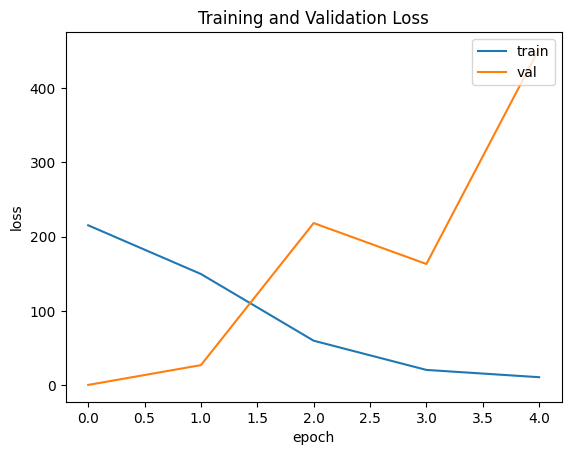

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

Let's evaluate the model using the test data and display some of the predictions:


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


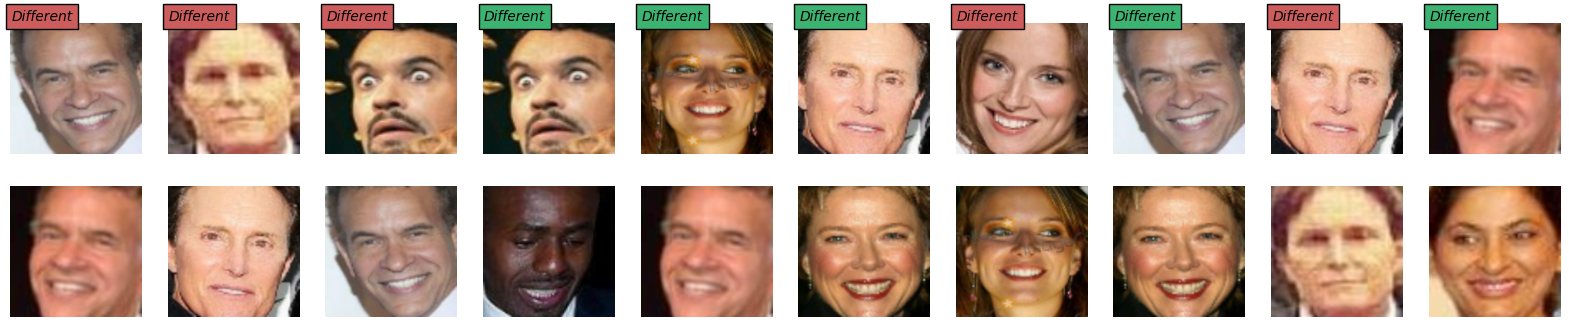

In [22]:
predictions = model.predict([x_test_pairs[:, 0], x_test_pairs[:, 1]]) >= 0.5
display_pairs(x_test_pairs, predictions, predictions == y_test_pairs)

Finally, we can compute the accuracy of the model on the test data:


In [23]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.50


These are the different layers of the model we trained:


In [24]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

We can reference the sequential model to generate embeddings for new images:


In [25]:
embedding_model = model.layers[2]

Let's select two random images representing the same person, and one image representing the other person:


In [30]:
person = np.where(y_test == 29)[0]
index1 = np.random.choice(person)
index2 = np.random.choice(person)
index3 = np.random.choice(np.where(y_test == 46)[0])

index1, index2, index3

(0, 0, 1)

We can generate the embeddings for these 3 images:


In [31]:
x_test_1 = np.expand_dims(x_test[index1], axis=0)  # Add batch dimension
x_test_2 = np.expand_dims(x_test[index2], axis=0)
x_test_3 = np.expand_dims(x_test[index3], axis=0)

embedding1 = embedding_model.predict(x_test_1)
embedding2 = embedding_model.predict(x_test_2)
embedding3 = embedding_model.predict(x_test_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


The distance between the embeddings of the two images representing the person 1 should be really small (close to 0):


In [32]:
norm(embedding1 - embedding2).numpy()

0.0

The distances between the embeddings of the images representing the first person and the image representing the second person should be large (close to 1):


In [33]:
norm(embedding1 - embedding3).numpy(), norm(embedding2 - embedding3).numpy()

(139.61188, 139.61188)

Save the model:


In [34]:
model.save('output/face_embedding.h5')

Test the model we have saved:


In [51]:
from keras.models import load_model
from keras.utils import load_img, img_to_array

model = load_model('output/face_embedding.h5', custom_objects={
                   'euclidean_distance': euclidean_distance},
                   compile=False)
embedding_model = model.layers[2]


def process_img(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = extract_face(img, minSize=(10, 10))
    img = np.expand_dims(img, axis=0)
    return img


embedding1 = embedding_model.predict(process_img('3.jpg'))
embedding2 = embedding_model.predict(process_img('4.jpg'))

norm(embedding1 - embedding2).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


0.2848551